In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import time

# from d2l import  torch as d2l

# 将图片转成tensor
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data",  # 下载目录为当前目录上一级中的data中
    train=True,  # 训练集
    transform=trans,  # 类型为pytorch的tensor，而不是图片
    download=False  # 需要下载数据集
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data",
    train=False,
    transform=trans,
    download=False
)
print(len(mnist_train))
print(len(mnist_test))

60000
10000


In [12]:
# 可视化数据集的函数
def get_fashion_mnist_labels(labels):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in labels]


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
    plt.show()

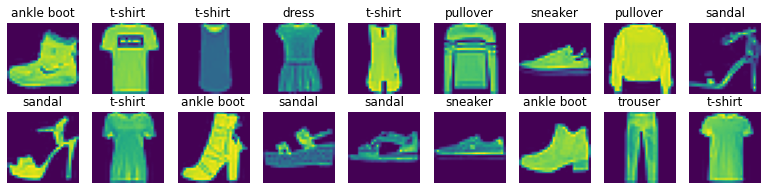

In [13]:
x, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(x.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [14]:
batch_size = 256

def get_dataloader_workers():
    #使用4个进程俩读取数据
    return 4

train_iter = data.DataLoader(mnist_train,
                             batch_size,
                             shuffle=True,
                             num_workers=get_dataloader_workers())

# 记录开始时间
start_time = time.time()
# 运行循环
for x, y in train_iter:
    continue
# 记录结束时间
end_time = time.time()
# 计算并显示运行时间
elapsed_time = end_time - start_time
print(f'{elapsed_time:.2f} sec')

2.11 sec


In [15]:
def load_data_fashion_mnist(batch_size,resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
            root="../data",  # 下载目录为当前目录上一级中的data中
            train=True,  # 训练集
            transform=trans,  # 类型为pytorch的tensor，而不是图片
            download=False  # 需要下载数据集
    )
    mnist_test = torchvision.datasets.FashionMNIST(
            root="../data",
            train=False,
            transform=trans,
            download=False
    )
    return (data.DataLoader(mnist_train,
                             batch_size,
                             shuffle=True,
                             num_workers=get_dataloader_workers()),
             data.DataLoader(mnist_test,
                             batch_size,
                             shuffle=True,
                             num_workers=get_dataloader_workers()))

# softmax回归的从零开始实现

In [16]:
import torch
import IPython.display as display

batch_size = 256
train_iter,test_iter = load_data_fashion_mnist(batch_size)

In [17]:
num_inputs = 784 #展平每个图像，将它们视为长度为784的向量
num_outputs = 10 #因为数据集有10个类别，所以网络输出维度为10

W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

In [18]:
X = torch.tensor([[1.0,2.0,3.0],
                 [4.0,5.0,6.0]])
print(X.sum(0,keepdim=True)) # 0,按列求和
print(X.sum(1,keepdim=True)) #1，按行求和

tensor([[5., 7., 9.]])
tensor([[ 6.],
        [15.]])


实现softmax
$$
\text{softmax}(X)_{ij} = \frac{\exp(X_{ij})}{\sum_{k} \exp(X_{ik})}
$$


In [19]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim=True)
    return X_exp/partition

def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent.

    Defined in :numref:`sec_utils`"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
lr = 0.1
def updater(batch_size):
    return sgd([W,b],lr,batch_size)

In [20]:
x = torch.normal(0,1,(2,5))
x_prob = softmax(x)
print(x_prob)
print(x_prob.sum(1))

tensor([[0.0465, 0.0423, 0.0114, 0.8354, 0.0644],
        [0.0843, 0.5340, 0.1317, 0.0287, 0.2213]])
tensor([1., 1.])


In [21]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)

In [22]:
y = torch.tensor([0,2]) #真实的标号值
y_hat = torch.tensor([[0.1,0.3,0.6], #第0个样本的预测值
                     [0.3,0.2,0.5]]) # 第1个样本的预测值
y_hat[[0,1],y]
"""0:对第0号样本中拿出y_0对应的元素y中的0号元素，也就是0，再对应到y_hat中的是第0个样本元素所以是0.1
   1:对第1号样本中拿出y_1对应的元素y中的1号元素，也就是2，再对应到y_hat中的是第2个样本元素所以是0.5
"""

'0:对第0号样本中拿出y_0对应的元素y中的0号元素，也就是0，再对应到y_hat中的是第0个样本元素所以是0.1\n   1:对第1号样本中拿出y_1对应的元素y中的1号元素，也就是2，再对应到y_hat中的是第2个样本元素所以是0.5\n'

In [23]:
#实现交叉熵损失函数
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])
cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

In [24]:
#将预测类别与真实一y元素进行比较
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat,y)/len(y)

0.5

In [25]:
#Accumulator的实现，实例中创建了2个变量，用于分别存储正确预测是数量和预测的总数
class Accumulator:
    def __init__(self,n):
        self.data = [0.0]*n
    def add(self,*args):
        self.data = [a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data = [0.0]*len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]


In [26]:
# 评估在任意模型net的准确率
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数，预测总数
    for x,y in data_iter:
        metric.add(accuracy(net(x),y),y.numel()) #y.numel()样本总数
    return metric[0]/metric[1] # 返回 分类正确的数/总样本数 就得到准确率
evaluate_accuracy(net,test_iter)

0.0905

In [27]:
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()  #如果用nn.Module，这里就是告诉pytorch进入训练模式要计算梯度
    metric = Accumulator(3)
    for x,y in train_iter:
        y_hat = net(x)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l)*len(y),accuracy(y_hat,y),
                y.size().numel()
            )
        else:
            l.sum().backward()
            updater(x.shape[0])
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]

In [28]:
def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')
#
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [29]:
#训练函数
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,num_epochs*0.1],
                       legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch+1,train_metrics+(test_acc,))
    train_loss,train_acc = train_metrics

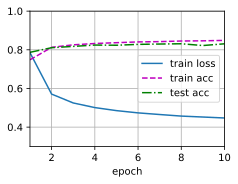

In [30]:
num_epochs =10
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

# softmax回归的简洁实现

In [31]:
import torch
from torch import nn

batch_size = 256
train_iter,test_iter = load_data_fashion_mnist(batch_size)

In [32]:
net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
        
net.apply(init_weights);

In [33]:
loss = nn.CrossEntropyLoss()

trainer = torch.optim.SGD(net.parameters(),lr=0.1)

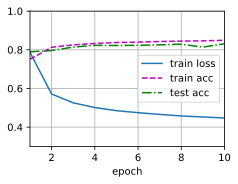

In [34]:
num_epochs = 10
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)